<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/vits/detection/DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [2]:
####################
# DATA PREPARATION #
####################

In [3]:
!git clone https://github.com/lizhogn/tiny_coco_dataset.git

Cloning into 'tiny_coco_dataset'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 121 (delta 7), reused 113 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 14.81 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100


revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)


def plot_im_with_boxes(im, boxes, probs=None, ax=None):
    """
    Plot an image and render bounding boxes with optional labels.

    Parameters
    ----------
    im : array-like or Tensor
        The image to display in HWC format.
    boxes : Tensor
        Bounding boxes in xyxy format with shape (N, 4).
    probs : Tensor, optional
        If 1-D: contains class IDs for each box.
        If 2-D: contains class probabilities per box (N, C).
        If None: no labels are drawn.
    ax : matplotlib.axes.Axes, optional
        Existing axes on which to draw. If omitted, a new figure is created.

    Notes
    -----
    Uses COLORS to differentiate boxes and CLASSES to map class IDs
    to human-readable labels.
    """

    if ax is None:
        plt.imshow(im)
        ax = plt.gca()

    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b

        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)

        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''

        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))


def preprocess_target(anno, im_w, im_h):
    """
    Convert COCO annotation dictionaries into normalized training targets.

    Parameters
    ----------
    anno : list of dict
        Raw COCO annotations for a single image. Must contain "bbox"
        in xywh format and "category_id".
    im_w : int
        Original image width in pixels.
    im_h : int
        Original image height in pixels.

    Returns
    -------
    classes : Tensor
        Class IDs for valid bounding boxes.
    boxes : Tensor
        Bounding boxes in normalized cxcywh format.

    Notes
    -----
    - Filters out annotations with "iscrowd" == 1.
    - Converts xywh → xyxy.
    - Removes invalid or degenerate boxes.
    - Normalizes coordinates to [0, 1].
    - Converts xyxy → cxcywh for downstream models.
    """

    anno = [obj for obj in anno
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)

    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes


class MyCocoDetection(datasets.CocoDetection):
    """
    A thin wrapper around torchvision.datasets.CocoDetection that applies
    preprocessing transforms to images and annotations.

    Adds:
    - Image transforms: tensor conversion, normalization, fixed-size resize.
    - Annotation preprocessing: COCO xywh → normalized cxcywh.
    """

    def __init__(self, *args, **kwargs):
        """
        Initialize the dataset wrapper.

        Parameters
        ----------
        *args, **kwargs : passed to CocoDetection
            Standard initialization parameters such as the image root
            directory and annotation file path.
        """
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.485, .456, .406],
                        std=[.229, .224, .225]),
            T.Resize((self.edge, self.edge), antialias=True)
        ])

        self.T_target = preprocess_target

    def __getitem__(self, idx):
        """
        Fetch an item and apply both image and annotation preprocessing.

        Parameters
        ----------
        idx : int
            Dataset index.

        Returns
        -------
        image_tensor : Tensor
            Preprocessed image of shape (3, edge, edge).
        (classes, boxes) : tuple
            Processed annotations where:
            - classes: Tensor of class IDs
            - boxes: Tensor of normalized cxcywh bounding boxes
        """
        img, target = super().__getitem__(idx)
        # PIL image
        w, h = img.size

        input_ = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_, (classes, boxes)


def collate_fn(inputs):
    """
    Custom collate function for DataLoader to batch fixed-size images
    while keeping variable-sized bounding-box annotations.

    Parameters
    ----------
    inputs : list
        Each element is (image_tensor, (classes, boxes)).

    Returns
    -------
    batched_images : Tensor
        A stacked tensor of images of shape (B, 3, H, W).
    (classes, boxes) : tuple
        Tuples of length B containing class tensors and box tensors
        for each image.
    """
    input_ = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple([i[1][1] for i in inputs])
    return input_, (classes, boxes)


In [5]:
train_ds = MyCocoDetection(
    'tiny_coco_dataset/tiny_coco/train2017/',
    'tiny_coco_dataset/tiny_coco/annotations/instances_train2017.json',
)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f'\nNumber of training samples: {len(train_ds)}')
# Number of training samples: 50

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Number of training samples: 50


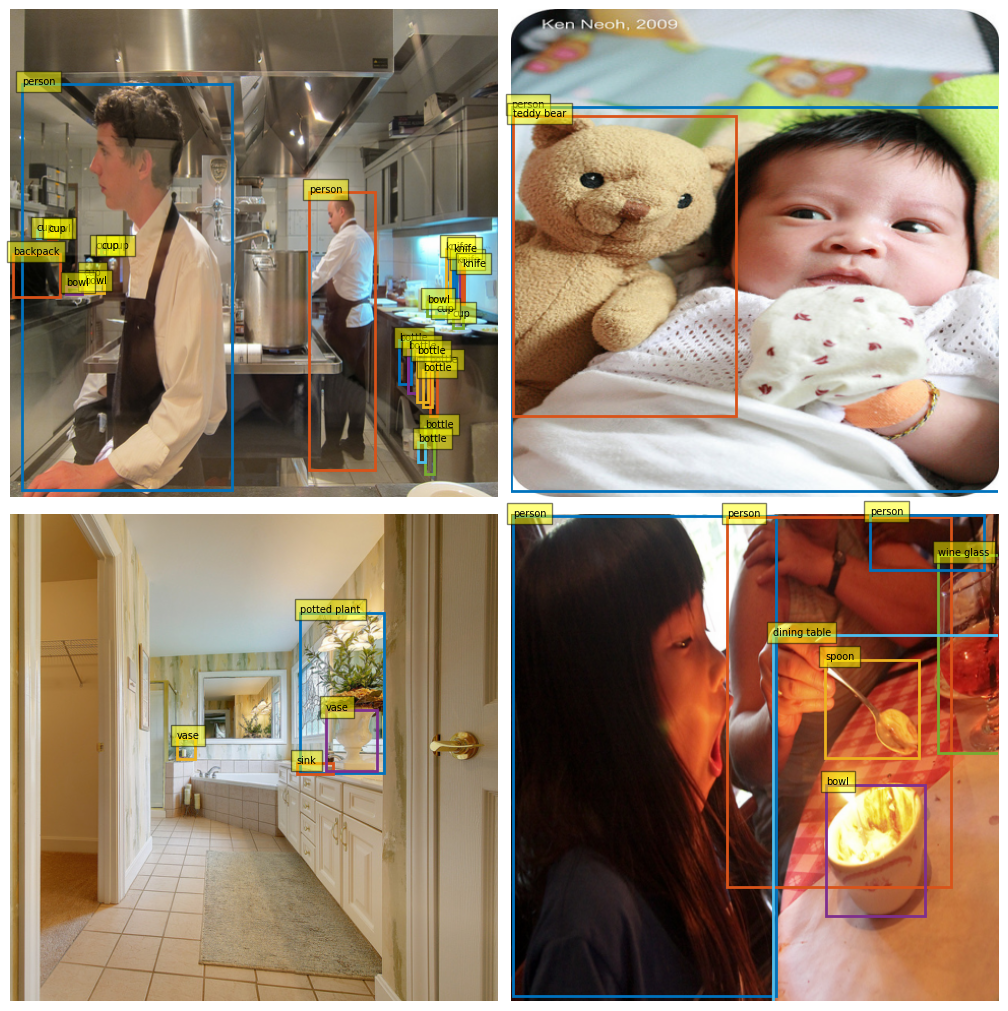

In [6]:
input_, (target) = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix]
    t_bbox = target[1][ix]

    t_bbox = ops.box_convert(
        t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].\
        permute(1,2,0).cpu().clip(0,1)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()

In [7]:
######################
# MODEL ARCHITECTURE #
######################

In [8]:
backbone = create_feature_extractor(
    torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True),
    return_nodes={'layer4': 'layer4'}
)

d_model = 256
conv1x1 = nn.Conv2d(2048, d_model, kernel_size=1, stride=1)

x = torch.randn((1, 3, 480, 480))
embeddings = backbone(x)['layer4']
embeddings = conv1x1(embeddings)

print(x.shape, embeddings.shape)
# torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 86.0MB/s]


torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])


In [9]:
### Positional Embeddings

In [10]:
embeddings_old = embeddings.clone()
embeddings = rearrange(embeddings, 'b c h w -> b (h w) c')

print(embeddings_old.shape, embeddings.shape)
# torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])

torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])


In [11]:
# the original implementation uses sine spatial PE
n_tokens = 225

inp_pe = nn.Parameter(
    torch.rand((1, n_tokens, d_model)),
    requires_grad=False
)

embeddings += inp_pe

print(inp_pe.shape, embeddings.shape)
# torch.Size([1, 225, 256]) torch.Size([1, 225, 256])

torch.Size([1, 225, 256]) torch.Size([1, 225, 256])


In [12]:
### Encoder

In [13]:
n_heads = 8
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=n_heads,
    dim_feedforward=4*d_model,
    batch_first=True
)

n_layers = 6
transformer_encoder = nn.TransformerEncoder(
    encoder_layer, num_layers=n_layers)

out_encoder = transformer_encoder(embeddings)

print(out_encoder.shape)
# torch.Size([1, 225, 256])

torch.Size([1, 225, 256])


In [14]:
### Decoder

In [15]:
n_queries = 100

queries = nn.Parameter(
    torch.rand((1, n_queries, d_model)),
    requires_grad=False
)

print(queries.shape, embeddings.shape)
# torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


In [16]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_model,
    nhead=n_heads,
    dim_feedforward=4*d_model,
    batch_first=True
)

transformer_decoder = nn.TransformerDecoder(
    decoder_layer, num_layers=n_layers)

out_decoder = transformer_decoder(queries, out_encoder)

print(out_decoder.shape, queries.shape, out_encoder.shape)
# torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


In [17]:
### Feed Forward

In [18]:
n_classes = 92

linear_class = nn.Linear(d_model, n_classes)
linear_bbox = nn.Linear(d_model, 4)

pred_classes = linear_class(out_decoder)
pred_bboxes = linear_bbox(out_decoder)

print(pred_classes.shape, pred_bboxes.shape)
# torch.Size([1, 100, 92]) torch.Size([1, 100, 4])

torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


In [19]:
def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook


class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=92, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=0.1,
            batch_first=True,
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4*d_model,
            dropout=0.1,
            batch_first=True
        )

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))


    def train(self, mode=True):
        def freeze_batchnorm(module):
            # Switch to evaluation mode (uses running stats)
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                for param in module.parameters():
                    param.requires_grad = False

        super().train(mode=mode)
        self.backbone.apply(freeze_batchnorm)

    def forward(self, x):
        tokens = self.backbone(x)['layer4']
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)

        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }

        return outs

In [20]:
detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=100
)

x = torch.randn((1, 3, 480, 480))
outs = detr(x)
pred_cl, pred_boxes = outs['layer_5'].values()

print(pred_cl.shape, pred_boxes.shape)
# torch.Size([1, 100, 92]) torch.Size([1, 100, 4])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


In [21]:
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]

o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)
out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]

o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)

torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)
torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)


In [22]:
# Transform indices to tensors
o_ixs = torch.IntTensor(o_ixs)
t_ixs = torch.IntTensor(t_ixs)

# Reorder o_ixs to naturally align with target_cl length, such
# the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
o_ixs = o_ixs[t_ixs.argsort()]

# Average over the number of boxes, not the number of coordinates
num_boxes = len(t_bbox)
loss_bbox = F.l1_loss(
    o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

# Vectorize the operation
target_gIoU = ops.generalized_box_iou(
    ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)
# Get only the matrix diagonal that contains the bipartite pairs
# and transform gIoU into a loss
loss_giou = 1 - torch.diag(target_gIoU).mean()

# Assign empty class for the outside predictions
queries_classes_label = torch.full(o_probs.shape[:1], 91)
queries_classes_label[o_ixs] = t_cl
loss_class = F.cross_entropy(o_cl, queries_classes_label)

loss_total = 1*loss_class + 5*loss_bbox + 2*loss_giou
print(loss_total)
# tensor(5.5788, grad_fn=<AddBackward0>)

tensor(7.1854, grad_fn=<AddBackward0>)


/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [23]:
def compute_sample_loss(
    o_bbox, t_bbox, o_cl, t_cl, n_queries=100):

    # If  the example has none box, we just feed it with empty classes.
    if len(t_cl) > 0:

        t_bbox = t_bbox.cuda()
        t_cl = t_cl.cuda()

        o_probs = o_cl.softmax(dim=-1)

        # Negative sign here because we want the maximum magnitude
        C_classes = -o_probs[..., t_cl]

        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

        # Negative sign here because we want the maximum magnitude
        C_giou = -ops.generalized_box_iou(
            ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )

        C_total = 1*C_classes + 5*C_boxes + 2*C_giou

        # Convert the tensor to numpy array
        C_total = C_total.cpu().detach().numpy()

        # Find the optimum pairs that produces the minimum summation.
        # the method returns the pair indices
        o_ixs, t_ixs = linear_sum_assignment(C_total)

        # Transform indices to tensors
        o_ixs = torch.IntTensor(o_ixs)
        t_ixs = torch.IntTensor(t_ixs)

        # Reorder o_ixs to naturally align with target_cl length, such
        # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
        o_ixs = o_ixs[t_ixs.argsort()]

        # Average over the number of boxes, not the number of coordinates
        num_boxes = len(t_bbox)
        loss_bbox = F.l1_loss(
            o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

        # vectorize the operation
        target_gIoU = ops.generalized_box_iou(
            ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        # get only the matrix diagonal that contains the bipartite pairs
        # and transform gIoU into a loss
        loss_giou = 1 - torch.diag(target_gIoU).mean()

        # assign empty class for the outside predictions
        queries_classes_label = torch.full(o_probs.shape[:1], 91).cuda()
        queries_classes_label[o_ixs] = t_cl
        loss_class = F.cross_entropy(o_cl, queries_classes_label)

    else:
        queries_classes_label = torch.full((n_queries,), 91).cuda()
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0)

    return loss_class, loss_bbox, loss_giou

In [24]:
# Ensure saving directory exists
![ ! -d ckpts-tiny ] && mkdir ckpts-tiny

detr = DETR(d_model=256, n_classes=92, n_tokens=225,
            n_layers=6, n_heads=8, n_queries=100)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

for p in detr.backbone.parameters():
    p.requires_grad = False

transformer_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]

optimizer = AdamW([
    {'params': transformer_params, 'lr': 1e-5},
], weight_decay=1e-4)


nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR params: 35.2M


In [25]:
torch.set_grad_enabled(True)
detr.train()


batch_size = 16
train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn)


niters = 4000
print_every_n = 100
save_every_n = 1000
losses = []

hist = []
iters = 1


while iters <= niters:

    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()

        outs = detr(input_)

        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items():

            out['bbox'] = out['bbox'].sigmoid()

            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):

                loss_class, loss_bbox, loss_giou = compute_sample_loss(
                    o_bbox, t_bbox, o_cl, t_cl)

                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou

                loss += sample_loss / batch_size / len(outs)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()

        losses.append(loss.item())

        if iters % print_every_n == 0:
            loss_avg = np.mean(losses[-10:])
            print_text = f'iters: {iters},\tloss: {loss_avg:.4f}'
            print(print_text)
            print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')

            hist.append(loss_avg)
            losses = []

        if iters % save_every_n == 0 and iters > 0:
            str_iters = str(iters)
            str_iters = '0'*(6-len(str_iters)) + str_iters
            torch.save(detr.state_dict(), f'ckpts-tiny/model_it{str_iters}.pt')
            np.save(f'ckpts-tiny/hist_it{str_iters}.npy', hist)

        iters += 1
        if iters > niters:
            break

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iters: 100,	loss: 1.8994
loss_class: 0.2201	loss_bbox: 0.1077	loss_giou: 0.9795	
iters: 200,	loss: 1.6743
loss_class: 0.3298	loss_bbox: 0.0302	loss_giou: 0.4373	
iters: 300,	loss: 1.5921
loss_class: 0.5257	loss_bbox: 0.0107	loss_giou: 0.7734	
iters: 400,	loss: 1.5737
loss_class: 0.7486	loss_bbox: 0.0113	loss_giou: 0.7220	
iters: 500,	loss: 1.5489
loss_class: 0.2375	loss_bbox: 0.0345	loss_giou: 0.9458	
iters: 600,	loss: 1.5088
loss_class: 1.3572	loss_bbox: 0.0123	loss_giou: 0.9743	
iters: 700,	loss: 1.4471
loss_class: 0.6155	loss_bbox: 0.0075	loss_giou: 0.8121	
iters: 800,	loss: 1.4693
loss_class: 0.0280	loss_bbox: 0.0000	loss_giou: 0.0000	
iters: 900,	loss: 1.3845
loss_class: 0.6967	loss_bbox: 0.0083	loss_giou: 0.6708	
iters: 1000,	loss: 1.4185
loss_class: 0.4045	loss_bbox: 0.0060	loss_giou: 0.7267	
iters: 1100,	loss: 1.3928
loss_class: 0.6179	loss_bbox: 0.0047	loss_giou: 0.7583	
iters: 1200,	loss: 1.3870
loss_class: 0.4145	loss_bbox: 0.0110	loss_giou: 0.8314	
iters: 1300,	loss: 1.3525

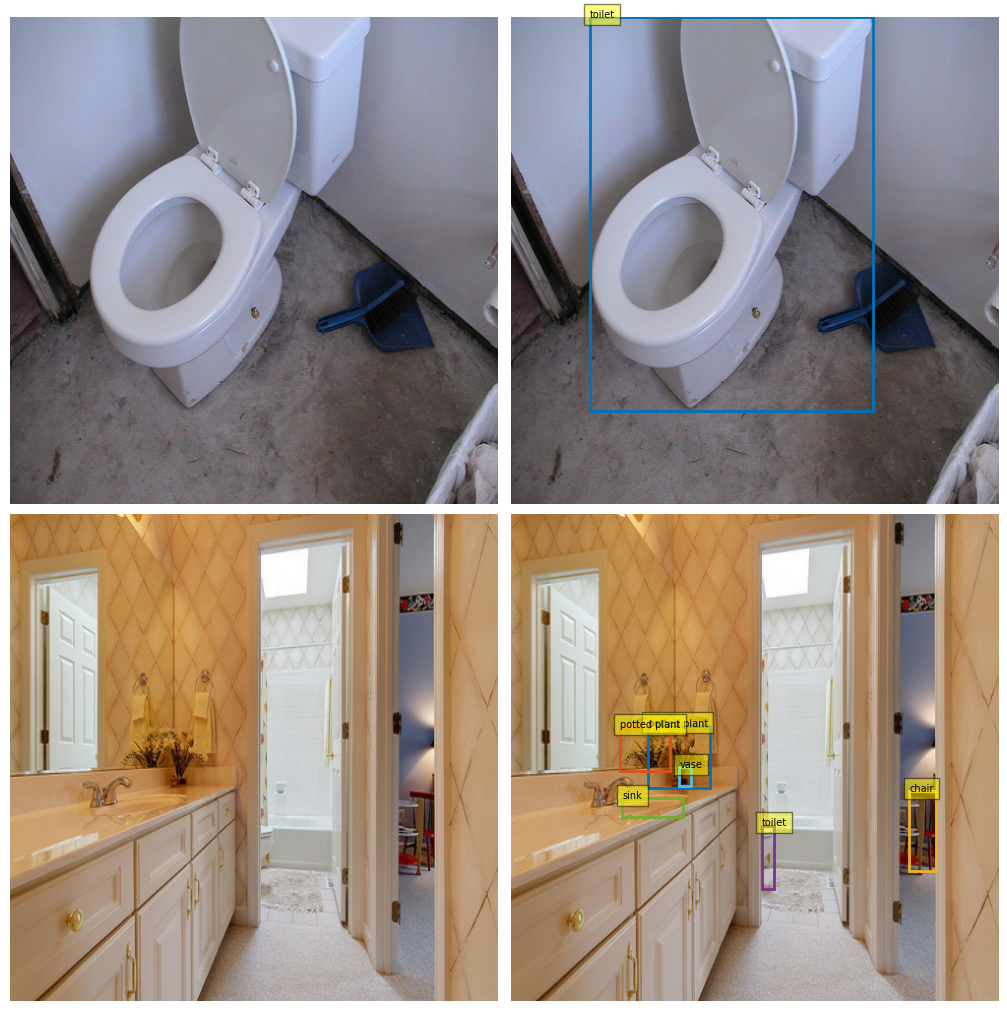

In [26]:
torch.set_grad_enabled(False)
detr.eval()

eval_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True,
    collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()


fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]

for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])